<a href="https://colab.research.google.com/github/yoyadima/DA/blob/main/Sber_gender_predict_simple_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Описание данных
### Таблица ```transactions```
##### Описание
Таблица содержит историю транзакций клиентов банка за один год и три месяца.

##### Формат данных

```
customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
111111,15 01:40:52,1111,1000,-5224,111111
111112,15 15:18:32,3333,2000,-100,11122233
...
```
##### Описание полей

 - ```customer_id``` — идентификатор клиента;
 - ```tr_datetime``` — день и время совершения транзакции (дни нумеруются с начала данных);
 - ```mcc_code``` — mcc-код транзакции;
 - ```tr_type``` — тип транзакции;
 - ```amount``` — сумма транзакции в условных единицах со знаком; ```+``` — начисление средств клиенту (приходная транзакция), ```-``` — списание средств (расходная транзакция);
 - ```term_id``` — идентификатор терминала;


### Таблица ```gender_train```

##### Описание
Данная таблица содержит информацию по полу для части клиентов, для которых он известен. Для остальных клиентов пол неизвестен.

##### Формат данных
```
customer_id,gender
111111,0
111112,1
...
```

##### Описание полей
 - ```customer_id``` — идентификатор клиента;
 - ```gender``` — пол клиента;

### Таблица ```tr_mcc_codes```

##### Описание
Данная таблица содержит описание mcc-кодов транзакций.

##### Формат данных
```
mcc_code;mcc_description
1000;словесное описание mcc-кода 1000
2000;словесное описание mcc-кода 2000
...
```

##### Описание полей
 - ```mcc_code``` – mcc-код транзакции;
 - ```mcc_description``` — описание mcc-кода транзакции.

### Таблица ```tr_types```

##### Описание
Данная таблица содержит описание типов транзакций.

##### Формат данных
```
tr_type;tr_description
1000;словесное описание типа транзакции 1000
2000;словесное описание типа транзакции 2000
...
```

##### Описание полей
 - ```tr_type``` – тип транзакции;
 - ```tr_description``` — описание типа транзакции;

##EDA

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks

from warnings import filterwarnings

%matplotlib inline
filterwarnings('ignore')

In [2]:
# Считываем данные
tr_mcc_codes = pd.read_csv('/content/drive/MyDrive/Python_And_Data_Analysis/data/tr_mcc_codes.csv', sep=';', index_col='mcc_code')
tr_types = pd.read_csv('/content/drive/MyDrive/Python_And_Data_Analysis/data/tr_types.csv', sep=';', index_col='tr_type')

transactions = pd.read_csv('/content/drive/MyDrive/Python_And_Data_Analysis/data/transactions.csv', index_col='customer_id')
gender_train = pd.read_csv('/content/drive/MyDrive/Python_And_Data_Analysis/data/gender_train.csv', index_col='customer_id')
transactions = transactions.join(gender_train, how='inner')


In [3]:
transactions.dropna(subset=['gender'], inplace=True)

In [4]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3751083 entries, 22899 to 99999680
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   tr_datetime  object 
 1   mcc_code     int64  
 2   tr_type      int64  
 3   amount       float64
 4   term_id      object 
 5   gender       int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 200.3+ MB


In [5]:
transactions.describe()

,mcc_code,tr_type,amount,gender
count,3.751083e+06,3.751083e+06,3.751083e+06,3.751083e+06
mean,5.586440e+03,2.439805e+03,-2.138264e+04,4.769004e-01
std,6.040523e+02,2.215249e+03,5.438054e+05,4.994662e-01
min,7.420000e+02,1.000000e+03,-1.459845e+08,0.000000e+00
25%,5.211000e+03,1.030000e+03,-2.245916e+04,0.000000e+00
50%,5.541000e+03,1.110000e+03,-5.614790e+03,0.000000e+00
75%,6.010000e+03,2.370000e+03,-1.122960e+03,1.000000e+00
max,9.402000e+03,8.146000e+03,1.459845e+08,1.000000e+00


In [6]:
transactions.head(10)

,tr_datetime,mcc_code,tr_type,amount,term_id,gender
customer_id,,,,,,
22899,1 15:26:45,4814,1030,-4491.83,NaN,1
22899,2 20:52:48,4814,1030,-2245.92,NaN,1
22899,5 18:52:19,6011,2010,-44918.32,NaN,1
22899,6 12:28:22,6011,2010,-150476.36,NaN,1
22899,28 10:41:01,6010,7030,33688.74,NaN,1
22899,28 11:34:38,6011,2010,-31442.82,NaN,1
22899,48 13:41:12,6011,7010,112295.79,NaN,1
22899,52 01:13:37,4814,1030,-2245.92,NaN,1
22899,53 11:03:38,6011,2010,-42672.40,NaN,1


In [7]:
transactions.dtypes

tr_datetime     object
mcc_code         int64
tr_type          int64
amount         float64
term_id         object
gender           int64
dtype: object

In [8]:
transactions.isnull().sum()

tr_datetime          0
mcc_code             0
tr_type              0
amount               0
term_id        1519541
gender               0
dtype: int64

В первую очередь переопределим дату и время и попробуем привязать точные даты к каждой транзакции

In [9]:
transactions['day'] = transactions['tr_datetime'].str.split().apply(lambda x: int(x[0]))
transactions['hour'] = transactions['tr_datetime'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
transactions.drop(columns=['tr_datetime'], axis=1, inplace=True)
transactions

,mcc_code,tr_type,amount,term_id,gender,day,hour
customer_id,,,,,,,
22899,4814,1030,-4491.83,NaN,1,1,15
22899,4814,1030,-2245.92,NaN,1,2,20
22899,6011,2010,-44918.32,NaN,1,5,18
22899,6011,2010,-150476.36,NaN,1,6,12
22899,6010,7030,33688.74,NaN,1,28,10
...,...,...,...,...,...,...,...
99999680,5411,1110,-5659.71,31190432,1,444,0
99999680,6011,2110,-134754.95,406826,1,444,0
99999680,5541,1110,-11229.58,J038003,1,446,0


Теперь попробуем узнать какой период времени отражен в наших данных. Для этого построим график кол-ва трат mcc-кода "Флористика" от номера дня.

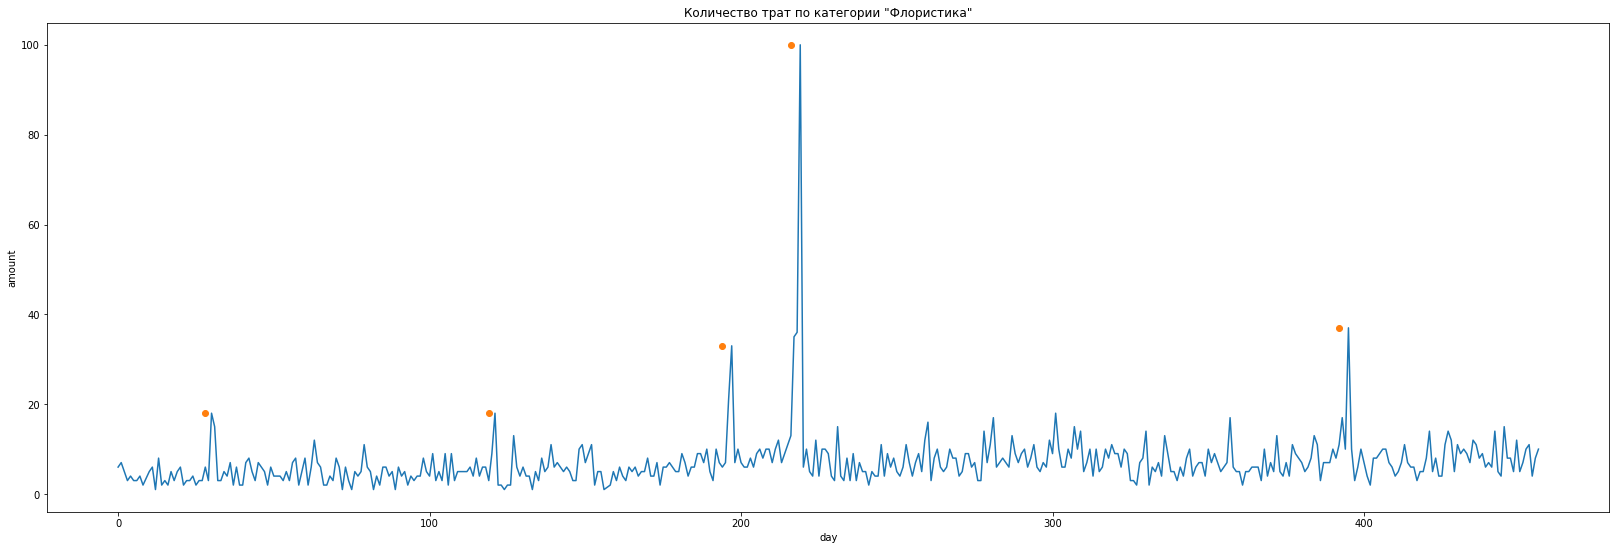

In [10]:
mcc_flor = tr_mcc_codes[tr_mcc_codes['mcc_description'].str.contains('Флор')].index[0]
flor_by_days = transactions[(transactions['mcc_code'] == mcc_flor) & (transactions['amount'] < 0)][['amount', 'day']]
flor_by_days = flor_by_days.groupby('day').count()


plt.figure(figsize=(28, 9))
sns.lineplot(data=flor_by_days, x='day', y='amount').set_title('Количество трат по категории "Флористика"')

#найдем пиковые значения кол-ва трат и отобразим их на графике
x = flor_by_days['amount'].values
peaks, _ = find_peaks(x, prominence=17)
plt.plot(peaks, x[peaks], "o")

In [11]:
#найдем дни, в которые были пиковые значения кол-ва трат
peak_days = flor_by_days[flor_by_days['amount'].isin(x[peaks])]
peak_days.drop(index=301, inplace=True)
peak_days_lst = peak_days.index.tolist()
peak_days

,amount
day,
30,18
121,18
197,33
219,100
395,37


Можно предположить в какой день в году люди тратят больше всего на цветы и получить точнst даты остальных пиков (предположим, что данные за 2014-2015 годы).

In [67]:
#transactions['date'] = transactions['day']
import datetime 
import time

day_0 = datetime.date(2015, 3, 8) - datetime.timedelta(days=219)
for i in peak_days_lst:
  day_i = day_0 + datetime.timedelta(days=i)
  print('Дата: {}, номер дня: {}'.format(day_i, i))

Дата: 2014-08-31, номер дня: 30
Дата: 2014-11-30, номер дня: 121
Дата: 2015-02-14, номер дня: 197
Дата: 2015-03-08, номер дня: 219
Дата: 2015-08-31, номер дня: 395


Логично будет предположить, что мужчины 8 марта тратят на цветы гораздо больше женщин, проверим это и посмотрим как соотносятся траты в этот день в целом.

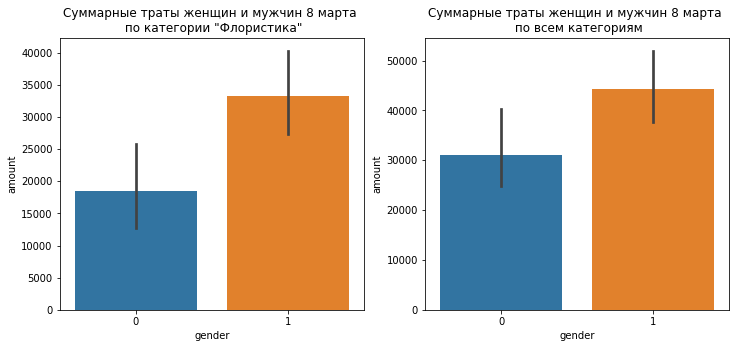

In [13]:
march_8_mcc_flor = transactions[(transactions['day'] == 219) & (transactions['amount'] < 0) & (transactions['mcc_code'] == mcc_flor)]
march_8_mcc_all = transactions[(transactions['day'] == 219) & (transactions['amount'] < 0)]
march_8_mcc_flor['amount'] = march_8_mcc_flor['amount'] * (-1)
march_8_mcc_all['amount'] = march_8_mcc_all['amount'] * (-1)

fig, ax = plt.subplots(1,2, figsize=(12, 5))
sns.barplot(data=march_8_mcc_flor, x='gender', y='amount', ax=ax[0]).set_title('Суммарные траты женщин и мужчин 8 марта \n по категории "Флористика"')
sns.barplot(data=march_8_mcc_all, x='gender', y='amount', ax=ax[1]).set_title('Cуммарные траты женщин и мужчин 8 марта \n по всем категориям')
fig.show()

Найдем самые популярные категории среди женщин и мужчин.

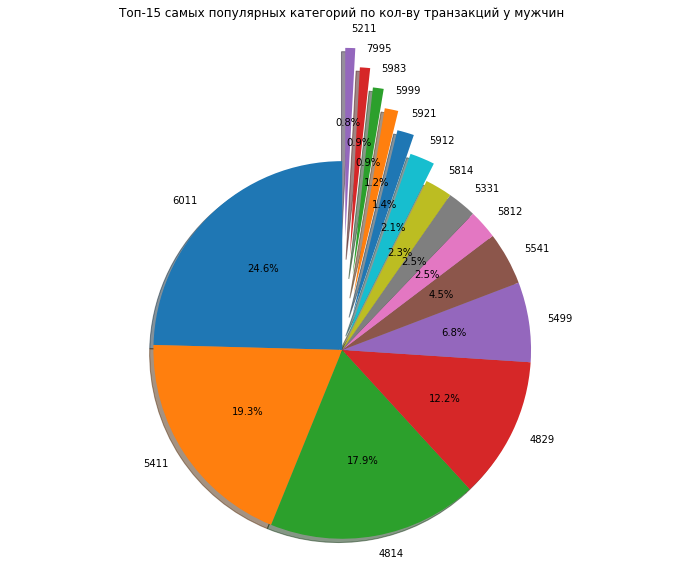

In [60]:
mcc_count_m = transactions[(transactions['amount'] < 0) & (transactions['gender'] == 1)].groupby(['mcc_code'])['mcc_code'].count()
mcc_count_m = mcc_count_m.to_frame()
mcc_count_m.rename(columns = {'mcc_code' : 'count_mcc'}, inplace = True)
mcc_count_m.reset_index(inplace=True)
mcc_count_m.sort_values(by=['count_mcc'], ascending=False, inplace=True)


labels = mcc_count_m['mcc_code'].head(15)
sizes = mcc_count_m['count_mcc'].head(15)
explode = (0, 0, 0, 0 , 0, 0, 0, 0, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(12, 10))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Топ-15 самых популярных категорий по кол-ву транзакций у мужчин") 
plt.show()

In [64]:
 tr_mcc_codes.loc[mcc_count_m['mcc_code'].head(15).tolist()]

,mcc_description
mcc_code,
6011,Финансовые институты — снятие наличности автом...
5411,"Бакалейные магазины, супермаркеты"
4814,"Звонки с использованием телефонов, считывающих..."
4829,Денежные переводы
5499,"Различные продовольственные магазины — рынки, ..."
5541,Станции техобслуживания
5812,"Места общественного питания, рестораны"
5331,Универсальные магазины
5814,"Рестораны, закусочные"


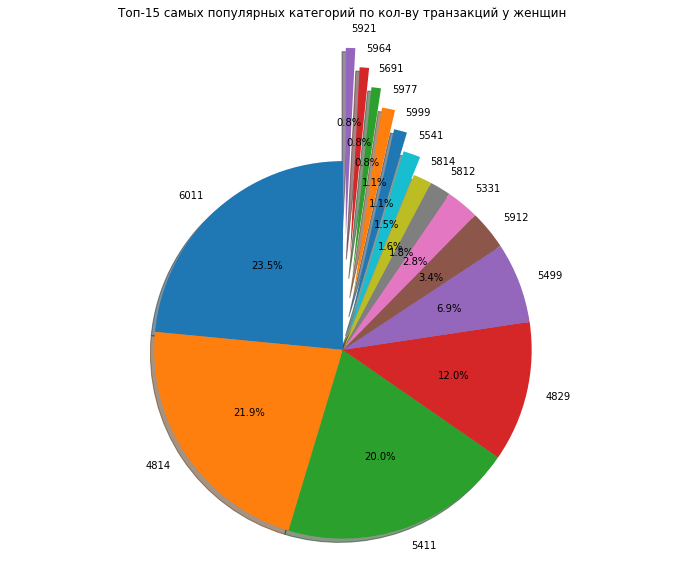

In [61]:
mcc_count_f = transactions[(transactions['amount'] < 0) & (transactions['gender'] == 0)].groupby(['mcc_code'])['mcc_code'].count()
mcc_count_f = mcc_count_f.to_frame()
mcc_count_f.rename(columns = {'mcc_code' : 'count_mcc'}, inplace = True)
mcc_count_f.reset_index(inplace=True)
mcc_count_f.sort_values(by=['count_mcc'], ascending=False, inplace=True)


labels = mcc_count_f['mcc_code'].head(15)
sizes = mcc_count_f['count_mcc'].head(15)
explode = (0, 0, 0, 0 , 0, 0, 0, 0, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(12, 10))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Топ-15 самых популярных категорий по кол-ву транзакций у женщин") 
plt.show()

In [65]:
 tr_mcc_codes.loc[mcc_count_f['mcc_code'].head(15).tolist()]

,mcc_description
mcc_code,
6011,Финансовые институты — снятие наличности автом...
4814,"Звонки с использованием телефонов, считывающих..."
5411,"Бакалейные магазины, супермаркеты"
4829,Денежные переводы
5499,"Различные продовольственные магазины — рынки, ..."
5912,Аптеки
5331,Универсальные магазины
5812,"Места общественного питания, рестораны"
5814,"Рестораны, закусочные"


Посмотрим как распределены траты по дням недели

In [73]:
transactions['day_of_week'] = transactions['day'].apply(lambda x: x % 7)
transactions

,mcc_code,tr_type,amount,term_id,gender,day,hour,night,day_of_week
customer_id,,,,,,,,,
22899,4814,1030,-4491.83,NaN,1,1,15,-2,1
22899,4814,1030,-2245.92,NaN,1,2,20,-2,2
22899,6011,2010,-44918.32,NaN,1,5,18,-2,5
22899,6011,2010,-150476.36,NaN,1,6,12,-2,6
22899,6010,7030,33688.74,NaN,1,28,10,-2,0
...,...,...,...,...,...,...,...,...,...
99999680,5411,1110,-5659.71,31190432,1,444,0,-1,3
99999680,6011,2110,-134754.95,406826,1,444,0,-1,3
99999680,5541,1110,-11229.58,J038003,1,446,0,-1,5


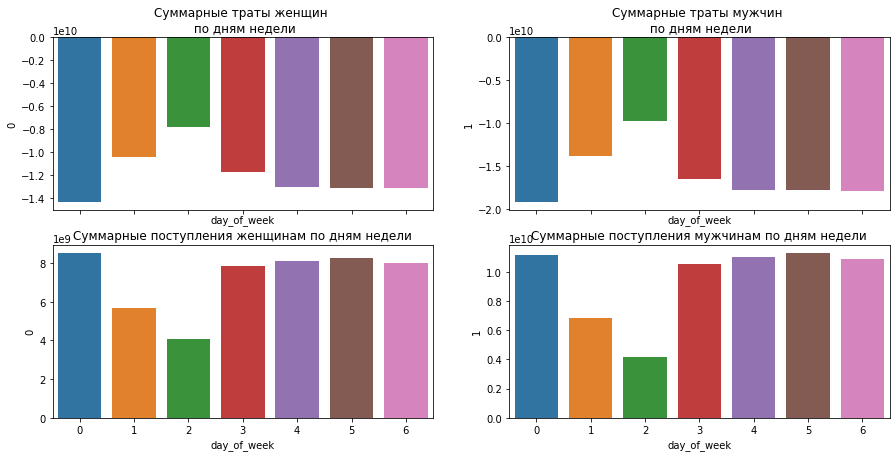

In [100]:


sum_neg_amount_by_day  = transactions[transactions['amount'] < 0].groupby(['day_of_week', 'gender'])['amount'].sum().unstack(-1)
sum_pos_amount_by_day  = transactions[transactions['amount'] > 0].groupby(['day_of_week', 'gender'])['amount'].sum().unstack(-1)

'''sum_amount_by_day = sum_amount_by_day.to_frame()
sum_amount_by_day.reset_index(inplace=True)
sum_amount_by_day['amount'] = -sum_amount_by_day['amount']'''
sum_neg_amount_by_day.reset_index(inplace=True)
sum_pos_amount_by_day.reset_index(inplace=True)

fig, ax = plt.subplots(2,2, figsize=(15, 7),  sharex=True)
sns.barplot(data=sum_neg_amount_by_day, x='day_of_week', y=0, ax=ax[0,0]).set_title('Суммарные траты женщин \n по дням недели')
sns.barplot(data=sum_neg_amount_by_day, x='day_of_week', y=1, ax=ax[0,1]).set_title('Cуммарные траты мужчин \n по дням недели')
sns.barplot(data=sum_pos_amount_by_day, x='day_of_week', y=0, ax=ax[1,0]).set_title('Суммарные поступления женщинам по дням недели')
sns.barplot(data=sum_pos_amount_by_day, x='day_of_week', y=1, ax=ax[1,1]).set_title('Cуммарные поступления мужчинам по дням недели')
fig.show()

Кто больше тратит в ночное время?

In [102]:
transactions['night'] = ~transactions['hour'].between(6, 22).astype(int)
transactions

,mcc_code,tr_type,amount,term_id,gender,day,hour,day_of_week,night
customer_id,,,,,,,,,
22899,4814,1030,-4491.83,NaN,1,1,15,1,-2
22899,4814,1030,-2245.92,NaN,1,2,20,2,-2
22899,6011,2010,-44918.32,NaN,1,5,18,5,-2
22899,6011,2010,-150476.36,NaN,1,6,12,6,-2
22899,6010,7030,33688.74,NaN,1,28,10,0,-2
...,...,...,...,...,...,...,...,...,...
99999680,5411,1110,-5659.71,31190432,1,444,0,3,-1
99999680,6011,2110,-134754.95,406826,1,444,0,3,-1
99999680,5541,1110,-11229.58,J038003,1,446,0,5,-1


In [120]:
sum_neg_amount_night_by_day = transactions[(transactions.amount < 0) & (transactions.night == -1)].groupby(['day_of_week', 'gender'])['amount'].mean().abs().unstack(-1)
sum_neg_amount_night_by_day.reset_index(inplace=True)
sum_neg_amount_night_by_day

gender,day_of_week,0,1
0,0,36481.285088,51150.443198
1,1,31562.279168,49912.555461
2,2,29013.562544,38369.841252
3,3,32085.681041,52175.325452
4,4,37648.486417,53398.401518
5,5,33963.938647,51404.015173
6,6,33493.197568,52439.009516


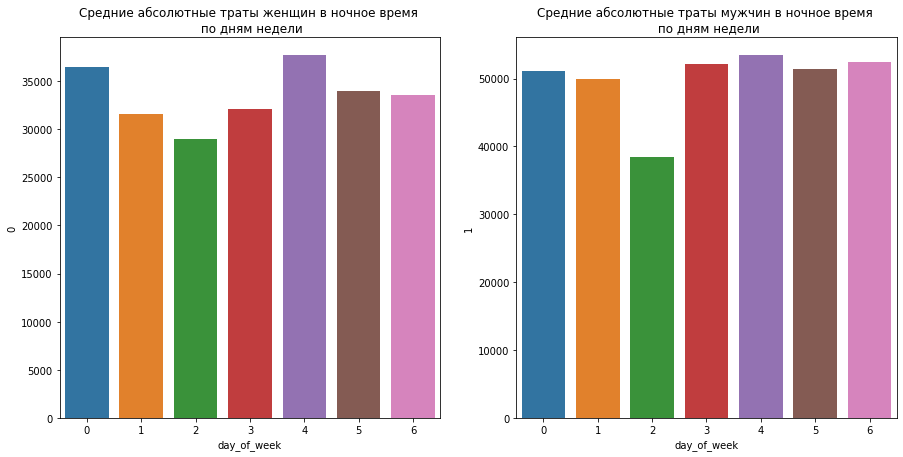

In [121]:
fig, ax = plt.subplots(1,2, figsize=(15, 7),  sharex=True)
sns.barplot(data=sum_neg_amount_night_by_day, x='day_of_week', y=0, ax=ax[0]).set_title('Средние абсолютные траты женщин в ночное время \n по дням недели')
sns.barplot(data=sum_neg_amount_night_by_day, x='day_of_week', y=1, ax=ax[1]).set_title('Средние абсолютные траты мужчин в ночное время \n по дням недели')
fig.show()